In [1]:
import time
import os
import sys
import logging

import numpy as np
import tenseal as ts

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, average_precision_score, f1_score, recall_score, precision_score, accuracy_score, classification_report
os.chdir("/home/apignet/homomorphic-encryption/ckks_titanic/")
from src.features import build_features
from models import encrypted_LR
from models import unencrypted_LR

In [2]:
%load_ext memory_profiler

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
1

1

# definition of parameters

### Log 

### Paths

In [4]:
#DATA_PATH = "/data/raw/"            # whole data set
#DATA_PATH = "/data/quick_demo/"   # subset of the data set, with 15 train_samples and 5 test_samples
#DATA_PATH = "/home/apignet/homomorphic-encryption/ckks_titanic/data/quick_demo/"   # subset of the data set, with 400 train_samples and 50 test_samples
DATA_PATH =   '/data/quick_demo/'
LOG_PATH = "reports/log"
LOG_FILENAME = "test_multiprocessing"

In [5]:
fileHandler = logging.FileHandler("{0}/{1}.log".format(LOG_PATH, LOG_FILENAME))
streamHandler = logging.StreamHandler(sys.stdout)
logging.basicConfig(format="%(asctime)s  [%(levelname)-8.8s]  %(message)s", datefmt='%m/%d/%Y %I:%M:%S %p', level = logging.INFO, handlers=[fileHandler, streamHandler])

In [6]:
os.getcwd()

'/home/apignet/homomorphic-encryption/ckks_titanic'

### Training variables

In [7]:
EPOCH = 40
LEARNING_RATE = 0.9
MOMENTUM_RATE = 0.6
REGULARIZATION_RATE = 0.5
VERBOSE = 2
SAVE_WEIGHT = 2
N_JOBS = 4

## Static functions

In [8]:
def crytp_array(X, local_context):
    """
    This function encrypt a list of vector
    
    :parameters 
    ------------
    
    :param X ; list of list, interpreted as list of vector to encrypt
    :param local_context ; TenSEAL context object used to encrypt
    
    :returns
    ------------
    
    list ; list of CKKS ciphertext  
    
    """
    res = []
    for i in range(len(X)):
        res.append(ts.ckks_vector(local_context, X[i]))
        if i == len(X) // 4:
            logging.info("25 % ...")
        elif i == len(X) // 2 :
            logging.info("50 % ...")
        elif i == 3* len(X)//4:
            logging.info("75% ...")
    return res

### Confidential functions

These functions involves security breachs (as use of unencrypted data, or decryption of weights) and cannot be coded by Alice.
However, the functions encapslulate the unsafe process, so can be performed by Alice if Bob provides them. 
Therefore, they are currently passed as parameters to Alice, which only calls them.

Currently there is a huge security breach, as confidential parameters (security key for instance), which are needed by those functions, are passed in a dictionnary to Alice. 
For a safe protocole, we have to change these functions, to set up a safe communication protocole between Bob and Alice.
Alice will therefore only send the crypted data to Bob (using these functions, in which can be set up the communication process) and Bob will locally perform the functions which are currently coded bellow. 

In [9]:
def refresh(ciphertext, **kwarg):
    """
    This function is here to refresh a ciphertext. This operation reset to 0 the calculus depth of the input ciphertext 
    WARNING :  Basically the function decryt and re-encrypt the ciphertext. 
    This is not safe, this operation needs to be done by a trusted part 
    (Bob for the perfect instance, even if it requieres communications between Alice and Bob while training)
    
    :parameters 
    ------------
    
    ciphertext ; encrypted CKKS vector 
    **kwarg ; dict, must contain context and secret_key.
    
    :returns
    ------------
    
    ciphertext : encrypted CKKS vector 
    
    """
    context = kwarg.get("context", None)
    secret_key = kwarg.get("secret_key", None)
    assert context , "Context must be provided with the key : context"+str(context)
    if context.is_private():
        return ts.ckks_vector(context, ciphertext.decrypt())
    else : 
        if not secret_key:
            raise AttributeError("The secret key is not provided and the context provided is public, decryption is not possible")
        else:
            return ts.ckks_vector(context, ciphertext.decrypt(secret_key))
   
            
def accuracy(crypted_weight, crypted_bias, prior_unencrypted_X = None, prior_unencrypted_Y=None, treshold = 0.5, verbose = True, **kwarg):
    """
    This function is here to compute the accuracy
    1-NOTE : we could maybe estimate this function homomorphically, by designing an approximation of the sign function. 
    However, this kind of approximation seems really hard to set up 
    Therefore, we will not be able to use the metric, as the result is encrypted.
    2-NOTE : this function could be parallelized, as we do not need the result for the next epoch. 
    
    :parameters 
    ------------
    
    crypted_weight ; encrypted CKKS vector (size equal to the number of features)
    crypted_bias ; encrypted CKKS vector (size 1)
    (Optionnal) prior_unencrypted_X ; samples on which the model accuracy will be computed. 
                                If not provided, the accuracy will be computed with the data provided in the kwarg
    (Optionnal) prior_unencrypted_Y ; labels on which the model accuracy will be computed. If not provided.
                                If not provided, the accuracy will be computed with the data provided in the kwarg
    threshold : default 0.5, use to classified the data from the probability computed
    verbose : Default True. If set to True, will log a report on F1, recall, precision, accuracy scores, and print the confusion matrix
    **kwarg ; dict, must contain context, secret_key, (Optionnal) unencrytped_X and (Optionnal) unencrypted_Y 
    
    :returns
    ------------
    
    accuray : float (rounded to 2 digits)
    
    
    """
    context = kwarg.get("context", None)
    if not context:
        raise AttributeError("Context must be provided in the **kwarg, with the key : context")
    secret_key = kwarg.get("secret_key", None)
    if prior_unencrypted_X is None:
        unencrypted_X = kwarg.get("unencrypted_X", None)
        if unencrypted_X is None:
            raise AttributeError("Unencrypted samples must be provided, either in the arguments, or in the **kwarg, with the key : unencrypted_X")
    else:
        unencrypted_X = np.array(prior_unencrypted_X)
    if prior_unencrypted_Y is None:
        unencrypted_Y = kwarg.get("unencrypted_Y", None)
        if unencrypted_Y is None:
            raise AttributeError("Unencrypted labels must be provided, either in the arguments, or in the **kwarg, with the key : unencrypted_Y")
    else:
        unencrypted_Y = np.array(prior_unencrypted_Y)
    if context.is_private():
            weight = np.array(crypted_weight.decrypt())
            bias = np.array(crypted_bias.decrypt())
    else : 
        if not secret_key:
            raise AttributeError("The secret key is not provided and the context provided is public, decryption is not possible. Pass a private context or the secret key")
        else:
            weight = np.array(crypted_weight.decrypt(secret_key))
            bias = np.array(crypted_bias.decrypt(secret_key))
            
    re = unencrypted_X.dot(weight) + bias  
    prediction = (np.float_power(re, 3)) * -0.004 + re * 0.197 + 0.5
    
    prediction = 1*(prediction > treshold)
    recall = recall_score(test_labels,prediction)
    F1 = f1_score(test_labels, prediction)
    precision = precision_score(test_labels, prediction)
    cf_m=confusion_matrix(test_labels, prediction ) 
    accuracy = accuracy_score(test_labels, prediction)
    if verbose:
        logging.info("Precision score of encrypted model on test set: %s " % precision)
        logging.info("Recall score  of encrypted model on test set : %s " % recall)
        logging.info("F1 score of encrypted model on test set: %s " % F1)
        logging.info("Accuracy of encrypted model on train set : %s " % accuracy)
        sns.heatmap(cf_m, annot=True)
    return {'precision': precision, 'recall':recall, 'F1 score':F1, "accuracy":accuracy, "confusion matrix":cf_m}
    

# Loading and processing the data

In [10]:
%%memit
logging.info(os.getcwd())
raw_train, raw_test = build_features.data_import(os.getcwd()+DATA_PATH)
train, submission_test = build_features.processing(raw_train, raw_test)
del submission_test

08/03/2020 02:35:52 PM  [INFO    ]  /home/apignet/homomorphic-encryption/ckks_titanic
08/03/2020 02:35:52 PM  [INFO    ]  loading the data into memory (pandas df)
08/03/2020 02:35:52 PM  [INFO    ]  Done
08/03/2020 02:35:52 PM  [INFO    ]  making final data set from raw data
08/03/2020 02:35:52 PM  [INFO    ]  Done
08/03/2020 02:35:52 PM  [INFO    ]  /home/apignet/homomorphic-encryption/ckks_titanic
08/03/2020 02:35:52 PM  [INFO    ]  loading the data into memory (pandas df)
08/03/2020 02:35:52 PM  [INFO    ]  Done
08/03/2020 02:35:52 PM  [INFO    ]  making final data set from raw data
08/03/2020 02:35:52 PM  [INFO    ]  Done
peak memory: 169.43 MiB, increment: 14.55 MiB


In [11]:
%%memit
train, test = train_test_split(train, test_size=0.15)
train_labels = train.Survived
test_labels = test.Survived
train_features = train.drop("Survived", axis=1)
test_features = test.drop("Survived", axis=1)

peak memory: 169.63 MiB, increment: 0.20 MiB


# Definition of safety parameters

In [12]:
%%memit
logging.info('Definition of safety parameters...')
timer = time.time()
# context = ts.context(ts.SCHEME_TYPE.CKKS, 32768,
# coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 60])
#context = ts.context(ts.SCHEME_TYPE.CKKS, 8192, coeff_mod_bit_sizes=[40, 21, 21, 21, 21, 21, 21, 40])

context = ts.context(ts.SCHEME_TYPE.CKKS, 16384, coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 40, 40,40, 60])
context.global_scale = pow(2, 40)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")


logging.info('Generation of the secret key...')
timer = time.time()
secret_key = context.secret_key()
#context.make_context_public() #drop the relin keys, the galois keys, and the secret keys. 
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
logging.info('Generation of the Galois Key...')
timer = time.time()
context.generate_galois_keys(secret_key)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
logging.info('Generation of the Relin Key...')
timer = time.time()
context.generate_relin_keys(secret_key)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
if context.is_public():
    logging.info("The context is now public, the context do not hold the secret key anymore, and decrypt methods need the secret key to be provide,")



08/03/2020 02:35:52 PM  [INFO    ]  Definition of safety parameters...
08/03/2020 02:35:53 PM  [INFO    ]  Done. 0.32 seconds
08/03/2020 02:35:53 PM  [INFO    ]  Generation of the secret key...
08/03/2020 02:35:53 PM  [INFO    ]  Done. 0.0 seconds
08/03/2020 02:35:53 PM  [INFO    ]  Generation of the Galois Key...
08/03/2020 02:35:56 PM  [INFO    ]  Done. 3.32 seconds
08/03/2020 02:35:56 PM  [INFO    ]  Generation of the Relin Key...
08/03/2020 02:35:56 PM  [INFO    ]  Done. 0.13 seconds
peak memory: 744.10 MiB, increment: 574.47 MiB


# Data encryption

In [13]:
%%memit
logging.info("Data encryption...")
timer = time.time()
encrypted_X = crytp_array(train_features.to_numpy().tolist(), context)
encrypted_Y = crytp_array(train_labels.to_numpy().reshape((-1, 1)).tolist(), context)
encrypted_test_X = crytp_array(test_features.to_numpy().tolist(), context)
encrypted_test_Y = crytp_array(test_labels.to_numpy().reshape((-1, 1)).tolist(), context)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")

08/03/2020 02:35:56 PM  [INFO    ]  Data encryption...
08/03/2020 02:35:56 PM  [INFO    ]  25 % ...
08/03/2020 02:35:56 PM  [INFO    ]  50 % ...
08/03/2020 02:35:56 PM  [INFO    ]  75% ...
08/03/2020 02:35:56 PM  [INFO    ]  25 % ...
08/03/2020 02:35:56 PM  [INFO    ]  50 % ...
08/03/2020 02:35:57 PM  [INFO    ]  75% ...
08/03/2020 02:35:57 PM  [INFO    ]  25 % ...
08/03/2020 02:35:57 PM  [INFO    ]  50 % ...
08/03/2020 02:35:57 PM  [INFO    ]  25 % ...
08/03/2020 02:35:57 PM  [INFO    ]  50 % ...
08/03/2020 02:35:57 PM  [INFO    ]  Done. 0.49 seconds
peak memory: 784.82 MiB, increment: 40.60 MiB


# Initialize the weight

The weights have to be crypted 

In [14]:
%%memit
unencrypted_weight = np.random.normal(loc=0,
                                      scale=0.2, size =(train_features.to_numpy().shape[1]))
logging.info(unencrypted_weight)
weight = ts.ckks_vector(context, unencrypted_weight.tolist())
unencrypted_bias = np.random.random((1))
bias = ts.ckks_vector(context, unencrypted_bias.tolist())

08/03/2020 02:35:57 PM  [INFO    ]  [-0.0702491   0.46902374  0.3494855  -0.23057593 -0.06257674  0.08766366
 -0.16432926  0.09853273 -0.22798694 -0.14406664  0.3747321   0.33195363
  0.09552228 -0.04046565  0.40655411 -0.18231959  0.12932264  0.04814169
  0.38856166 -0.00123001  0.02334827 -0.12767309 -0.1736485  -0.01535684
  0.05991035  0.18599332 -0.40438465  0.03565092  0.02549029  0.10802959
  0.45323312]
08/03/2020 02:35:57 PM  [INFO    ]  [ 0.12858387  0.05263818 -0.04909242  0.25137243  0.1927675  -0.07428396
  0.07617964 -0.08785105 -0.05557698 -0.03894221 -0.17548729 -0.2619084
  0.04941755 -0.14667116  0.21326407  0.14549226 -0.03105039  0.14257497
  0.07585576 -0.0769348   0.02969358 -0.04194939 -0.22062436  0.10714856
  0.05559916  0.03471234  0.16138949  0.26915611  0.03401468  0.00917517
 -0.13093246]
peak memory: 790.95 MiB, increment: 6.13 MiB


The confidential data as yet stored into a dictionnary, and will be used during the training only by functions which are passed as arguments to the fit methods. This encapsulation of sensitive data will allows us to ensure security during training later. 

In [15]:
%%memit
confidential_data = {'context':context,
                     'secret_key':secret_key, 
                     'unencrypted_X':train_features.to_numpy(),
                     'unencrypted_Y':train_labels.to_numpy().reshape((-1, 1)) 
                    }

peak memory: 790.95 MiB, increment: 0.00 MiB


# Training the unencrypted model

In [16]:
logging.info("Scikit Learn model initialization")
sk_model = LogisticRegression(penalty='l2', solver = 'lbfgs')

08/03/2020 02:35:57 PM  [INFO    ]  Scikit Learn model initialization


In [17]:
logging.info("Scikit Learn model training is starting.. ")
timer = time.time()
sk_model.fit(train_features, train_labels)
logging.info("Done. %s iterations in %s seconds" %(sk_model.n_iter_[0], time.time()-timer))

08/03/2020 02:35:57 PM  [INFO    ]  Scikit Learn model training is starting.. 
08/03/2020 02:35:57 PM  [INFO    ]  Done. 11 iterations in 0.006175994873046875 seconds


In [18]:
logging.info("Unencrypted model initialization")
unencrypted_model = unencrypted_LR.LogisticRegression(init_weight=unencrypted_weight,
                                                      init_bias=unencrypted_bias,
                                                      verbose=VERBOSE,
                                                      save_weight= SAVE_WEIGHT,
                                                      max_epoch=EPOCH,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum_rate=MOMENTUM_RATE,
                                                      reg_para=REGULARIZATION_RATE,
                                                      n_jobs = N_JOBS)

08/03/2020 02:35:57 PM  [INFO    ]  Unencrypted model initialization


In [19]:
logging.info("Training starting")
timer=time.time()
unencrypted_model.fit(train_features.to_numpy(), train_labels.to_numpy().reshape((-1, 1)))
logging.info("Training done. " + str(round(time.time() - timer, 0)) + " seconds")

08/03/2020 02:35:57 PM  [INFO    ]  Training starting
08/03/2020 02:35:57 PM  [INFO    ]  Just finished iteration number 0 in  0.0003044605255126953 seconds.
08/03/2020 02:35:57 PM  [INFO    ]  Starting computation of the loss ...
08/03/2020 02:35:57 PM  [INFO    ]  Loss : 1.775849772073132.
08/03/2020 02:35:57 PM  [INFO    ]  Just finished iteration number 1 in  0.000293731689453125 seconds.
08/03/2020 02:35:57 PM  [INFO    ]  Just finished iteration number 2 in  0.0002837181091308594 seconds.
08/03/2020 02:35:57 PM  [INFO    ]  Starting computation of the loss ...
08/03/2020 02:35:57 PM  [INFO    ]  Loss : 1.1870274707246518.
08/03/2020 02:35:57 PM  [INFO    ]  Just finished iteration number 3 in  0.0002696514129638672 seconds.
08/03/2020 02:35:57 PM  [INFO    ]  Just finished iteration number 4 in  0.00028634071350097656 seconds.
08/03/2020 02:35:57 PM  [INFO    ]  Starting computation of the loss ...
08/03/2020 02:35:57 PM  [INFO    ]  Loss : 0.9469890710361384.
08/03/2020 02:35:57

### Unencrypted accuracy and loss

08/03/2020 02:35:57 PM  [INFO    ]  Accuracy of unencrypted model : 0.5 


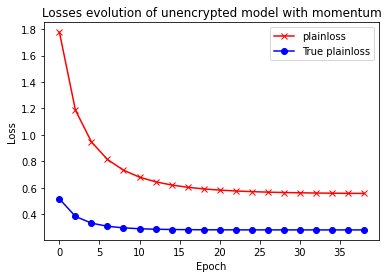

In [20]:
acc = unencrypted_model.accuracy(test_features.to_numpy(), test_labels.to_numpy().reshape((-1, 1)))
logging.info("Accuracy of unencrypted model : %s " % acc)

plt.plot([i*VERBOSE for i in range(len(unencrypted_model.loss_list))], unencrypted_model.loss_list,'-xr' ,label='plainloss')
plt.plot([i*VERBOSE for i in range(len(unencrypted_model.true_loss_list))], unencrypted_model.true_loss_list, '-ob', label='True plainloss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses evolution of unencrypted model with momentum')
plt.legend(loc='best')

# Training the crypted models

In [21]:
logging.info("Model initialization")
model = encrypted_LR.LogisticRegressionHE(init_weight=weight,
                                          init_bias=bias,
                                          refresh_function=refresh,
                                          context=context,
                                          confidential_kwarg=confidential_data,
                                          accuracy=accuracy,
                                          verbose=VERBOSE,
                                          save_weight=SAVE_WEIGHT,
                                          max_epoch=EPOCH,
                                          learning_rate=LEARNING_RATE,
                                          momentum_rate=MOMENTUM_RATE,
                                          reg_para=REGULARIZATION_RATE,
                                          n_jobs = N_JOBS)

08/03/2020 02:35:57 PM  [INFO    ]  Model initialization


In [22]:
logging.info("Training starting")
timer=time.time()
model.fit(encrypted_X, encrypted_Y)
logging.info("Training done. " + str(round(time.time() - timer, 0)) + " seconds")

08/03/2020 02:35:58 PM  [INFO    ]  Training starting
08/03/2020 02:35:58 PM  [INFO    ]  Starting serialization of data
08/03/2020 02:36:01 PM  [INFO    ]  Data serialization done in 3.4277944564819336 seconds
08/03/2020 02:36:01 PM  [INFO    ]  Initialization of 4 workers
08/03/2020 02:36:05 PM  [INFO    ]  Initialization done for process Process-17. Len of data : 2
08/03/2020 02:36:05 PM  [INFO    ]  Initialization done for process Process-18. Len of data : 2
08/03/2020 02:36:05 PM  [INFO    ]  Initialization done for process Process-19. Len of data : 2
08/03/2020 02:36:05 PM  [INFO    ]  Initialization done for process Process-20. Len of data : 2
08/03/2020 02:36:05 PM  [INFO    ]  Initialization done in 3.760517120361328 seconds


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/apignet/anaconda3/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/home/apignet/anaconda3/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/home/apignet/anaconda3/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/home/apignet/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/home/apignet/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
TypeError: can't pickle _tenseal_cpp.CKKSVector objects
TypeError: can't pickle _tenseal_cpp.CKKSVector objects
  File "/home/apignet/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
TypeError

KeyboardInterrupt: 

In [ ]:
acc_test = model.accuracy(test_features.to_numpy(), test_labels.to_numpy().reshape((-1, 1)))
acc_train = model.accuracy(train_features.to_numpy(), train_labels.to_numpy().reshape((-1,1)))
logging.info("Accuracy of encrypted model on test set: %s " % acc_test)
logging.info("Accuracy of encrypted model on train set : %s " % acc_train)


In [ ]:
unencrypted_X = test_features.to_numpy()
weight = model.weight.decrypt(secret_key)
bias = model.bias.decrypt(secret_key)
re = unencrypted_X.dot(weight) + bias  
prediction = (np.float_power(re, 3)) * -0.004 + re * 0.197 + 0.5
prediction = 1*(prediction > 0.5)
recall = recall_score(test_labels,prediction)
F1 = f1_score(test_labels, prediction)
precision = precision_score(test_labels, prediction)
cf_m=confusion_matrix(test_labels, prediction ) 
accuracy = accuracy_score(test_labels, prediction)

logging.info("Precision score of encrypted model on test set: %s " % precision)
logging.info("Recall score  of encrypted model on test set : %s " % recall)
logging.info("F1 score of encrypted model on test set: %s " % F1)
logging.info("Accuracy of encrypted model on train set : %s " % accuracy)
sns.heatmap(cf_m, annot=True)

In [ ]:
prediction = unencrypted_model.predict(test_features)
prediction = 1*(prediction > 0.5)
recall = recall_score(test_labels,prediction)
F1 = f1_score(test_labels, prediction)
precision = precision_score(test_labels, prediction)
cf_m=confusion_matrix(test_labels, prediction ) 
accuracy = accuracy_score(test_labels, prediction)

logging.info("Precision score of unencrypted model on test set: %s " % precision)
logging.info("Recall score  of unencrypted model on test set : %s " % recall)
logging.info("F1 score of unencrypted model on test set: %s " % F1)
logging.info("Accuracy of unencrypted model on train set : %s " % accuracy)
sns.heatmap(cf_m, annot=True)

In [ ]:
prediction = sk_model.predict(test_features)
prediction = 1*(prediction > 0.5)
recall = recall_score(test_labels,prediction)
F1 = f1_score(test_labels, prediction)
precision = precision_score(test_labels, prediction)
cf_m=confusion_matrix(test_labels, prediction ) 
accuracy = accuracy_score(test_labels, prediction)

logging.info("Precision score of scikit-learn model on test set: %s " % precision)
logging.info("Recall score  of scikit-learn model on test set : %s " % recall)
logging.info("F1 score of scikit-learn model on test set: %s " % F1)
logging.info("Accuracy of scikit-learn model on test set : %s " % accuracy)
sns.heatmap(cf_m, annot=True)

# Figures

## encrypted and unencrypted losses 

In [ ]:
plt.plot([i*VERBOSE for i in range(len(model.loss_list))], [i.decrypt(secret_key)[0] for i in model.loss_list],'-or', label='cipherloss')

plt.plot([i*VERBOSE for i in range(len(unencrypted_model.loss_list))], unencrypted_model.loss_list, label='plainloss')
plt.plot([i*VERBOSE for i in range(len(unencrypted_model.true_loss_list))], unencrypted_model.true_loss_list, label='True plainloss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses evolution of both models')
plt.legend(loc='best')

## Unencrypted loss

# Errors

## Relative error between losses

In [ ]:
decrypted = [i.decrypt(secret_key)[0] for i in model.loss_list]
true_err_cl = np.abs(np.array(decrypted) - np.array(unencrypted_model.loss_list))
rel_err_cl = true_err_cl/np.abs(decrypted)
true_err_ct = np.abs(np.array(decrypted) - np.array(unencrypted_model.true_loss_list))
rel_err_ct = true_err_ct/np.abs(decrypted)
true_err_lt = np.abs(np.array(unencrypted_model.loss_list) - np.array(unencrypted_model.true_loss_list))
rel_err_lt = true_err_lt/np.abs(unencrypted_model.true_loss_list)


In [ ]:
plt.plot([i*VERBOSE for i in range(len(model.loss_list))],  rel_err_cl, label='cipherloss and plainloss')
plt.plot([i*VERBOSE for i in range(len(model.loss_list))],  rel_err_ct, label='cipherloss and trueloss' )
plt.plot([i*VERBOSE for i in range(len(model.loss_list))],  rel_err_lt, label='plainlosses')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Relative error on loss')
plt.title('Relative error between losses')

## Relative error between weights

In [ ]:
dwl = np.array([i.decrypt(secret_key) for i in model.weight_list])
dbl = np.array([i.decrypt(secret_key) for i in model.bias_list]).reshape((-1,1))
dl = np.concatenate((dwl,dbl), axis=1)

ul = np.concatenate((np.array(unencrypted_model.weight_list), np.array(unencrypted_model.bias_list).reshape((-1,1))), axis=1)
w_err = np.mean((np.abs(dl-ul)/np.abs(ul)), axis=1)

In [ ]:
#plt.plot([i*VERBOSE for i in range(w_err.shape[0])],wm_err)
plt.plot([i*VERBOSE for i in range(w_err.shape[0])],w_err)
#plt.plot([i*VERBOSE for i in range(w_err.shape[0])],w2_err)


plt.xlabel('Epoch')
plt.ylabel('Relative error on weights')
plt.title('Relative error between encrypted weights and unencrypted weights')

In [ ]:
del encrypted_X, encrypted_Y